In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error

In [2]:
movies = pd.read_csv(
    "movies.dat",
    sep="::",
    engine="python",
    names=["movieId", "title", "genres"]
)

ratings = pd.read_csv(
    "ratings.dat",
    sep="::",
    engine="python",
    names=["userId", "movieId", "rating", "timestamp"]
)

In [3]:
print("Movies shape:", movies.shape)
print("Ratings shape:", ratings.shape)

movies.head()

Movies shape: (10681, 3)
Ratings shape: (10000054, 4)


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
print("Missing values in movies:")
print(movies.isnull().sum())

print("\nMissing values in ratings:")
print(ratings.isnull().sum())

Missing values in movies:
movieId    0
title      0
genres     0
dtype: int64

Missing values in ratings:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


In [5]:
# Create movieId → title mapping
movieid_to_title = dict(
    zip(movies["movieId"], movies["title"])
)


In [6]:
# Check rating distribution
ratings["rating"].value_counts().sort_index()


rating
0.5      94988
1.0     384180
1.5     118278
2.0     790306
2.5     370178
3.0    2356676
3.5     879764
4.0    2875850
4.5     585022
5.0    1544812
Name: count, dtype: int64

In [7]:
# STEP 5: Filter sparse users and movies

min_user_ratings = 15
min_movie_ratings = 15



In [8]:
user_counts = ratings["userId"].value_counts()
active_users = user_counts[user_counts >= min_user_ratings].index
ratings_filtered = ratings[ratings["userId"].isin(active_users)]


In [9]:
movie_counts = ratings_filtered["movieId"].value_counts()
popular_movies = movie_counts[movie_counts >= min_movie_ratings].index
ratings_filtered = ratings_filtered[ratings_filtered["movieId"].isin(popular_movies)]

In [10]:
print("Filtered ratings shape:", ratings_filtered.shape)
print("Unique users:", ratings_filtered["userId"].nunique())
print("Unique movies:", ratings_filtered["movieId"].nunique())


Filtered ratings shape: (9990308, 4)
Unique users: 69878
Unique movies: 9282


In [11]:
# Step 10: Limit to top users & movies for memory
top_users = ratings_filtered['userId'].value_counts().head(5000).index
top_movies = ratings_filtered['movieId'].value_counts().head(10000).index

train_sample_knn = ratings_filtered[
    ratings_filtered['userId'].isin(top_users) &
    ratings_filtered['movieId'].isin(top_movies)
]

# Build smaller item-user matrix (memory safe)
item_user_matrix = train_sample_knn.pivot_table(
    index='movieId',
    columns='userId',
    values='rating'
).fillna(0).astype(np.float32)

In [12]:
print("Item–User Matrix shape:", item_user_matrix.shape)


Item–User Matrix shape: (9282, 5000)


In [13]:

item_user_matrix_centered = item_user_matrix.subtract(
    item_user_matrix.mean(axis=0), axis=1
).fillna(0)

In [14]:
def train_test_split_userwise(data, test_size=0.2):
    train_data = []
    test_data = []

    for user_id in data["userId"].unique():
        user_ratings = data[data["userId"] == user_id]

        if len(user_ratings) < 10:
            continue

        train, test = train_test_split(
            user_ratings,
            test_size=test_size,
            random_state=42
        )

        train_data.append(train)
        test_data.append(test)

    return pd.concat(train_data), pd.concat(test_data)


train_data, test_data = train_test_split_userwise(ratings_filtered)

print("Train size:", train_data.shape)
print("Test size:", test_data.shape)

Train size: (7964762, 4)
Test size: (2025546, 4)


In [15]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

# Create the KNN model
knn_model = NearestNeighbors(
    metric="cosine",
    algorithm="brute",
    n_neighbors=20  # you can tune this
)

# Convert item-user matrix (centered or not) to sparse
sparse_matrix = csr_matrix(item_user_matrix.values)

# Fit the model
knn_model.fit(sparse_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [16]:
def recommend_movies_knn(user_id, k=20):
    user_ratings = train_data[
        (train_data["userId"] == user_id) &
        (train_data["rating"] >= 4)
    ]

    if user_ratings.empty:
        return []

    scores = {}

    for _, row in user_ratings.iterrows():
        movie_id = row["movieId"]

        if movie_id not in item_user_matrix.index:
            continue

        movie_vector = item_user_matrix.loc[movie_id].values.reshape(1, -1)

        distances, indices = knn_model.kneighbors(movie_vector, n_neighbors=15)

        for idx, dist in zip(indices[0], distances[0]):
            similar_movie = item_user_matrix.index[idx]

            if similar_movie == movie_id:
                continue

            scores[similar_movie] = scores.get(similar_movie, 0) + (1 - dist)

    watched = train_data[
        train_data["userId"] == user_id
    ]["movieId"].values

    recommendations = [
        (movie, score)
        for movie, score in scores.items()
        if movie not in watched
    ]

    recommendations.sort(key=lambda x: x[1], reverse=True)

    return [m[0] for m in recommendations[:k]]

In [18]:
def precision_recall_f1_at_k_knn(user_id, k=20):
    recommended = recommend_movies_knn(user_id, k)

    if len(recommended) == 0:
        return None, None, None

    relevant = test_data[
        (test_data["userId"] == user_id) &
        (test_data["rating"] >= 4)
    ]["movieId"].values

    if len(relevant) == 0:
        return None, None, None

    tp = len(set(recommended) & set(relevant))

    precision = tp / k
    recall = tp / len(relevant)
    f1 = 0 if precision + recall == 0 else \
         2 * precision * recall / (precision + recall)

    return precision, recall, f1

In [19]:
# STEP 10: Evaluation with user sampling (optimized)

np.random.seed(42)

user_test_counts = test_data["userId"].value_counts()
eligible_users = user_test_counts[user_test_counts >= 5].index

sample_users = np.random.choice(
    eligible_users,
    size=250,
    replace=False
)

In [20]:
user_id = sample_users[0]   
K = 10

recommended_movie_ids = recommend_movies_knn(user_id, k=K)

recommended_movies = movies[
    movies["movieId"].isin(recommended_movie_ids)
][["movieId", "title"]]

print(f"Top-{K} Recommended Movies for User {user_id}:\n")
recommended_movies.reset_index(drop=True)

Top-10 Recommended Movies for User 25338:



,movieId,title
0,32,12 Monkeys (Twelve Monkeys) (1995)
1,47,Seven (a.k.a. Se7en) (1995)
2,58,"Postman, The (Postino, Il) (1994)"
3,296,Pulp Fiction (1994)
4,608,Fargo (1996)
5,1089,Reservoir Dogs (1992)
6,1094,"Crying Game, The (1992)"
7,1172,Cinema Paradiso (Nuovo cinema Paradiso) (1989)
8,1206,"Clockwork Orange, A (1971)"
9,2997,Being John Malkovich (1999)


In [21]:
precisions, recalls, f1s = [], [], []

K = 20

for user_id in sample_users:
    p, r, f1 = precision_recall_f1_at_k_knn(user_id, k=K)
    if p is not None:
        precisions.append(p)
        recalls.append(r)
        f1s.append(f1)

print("Average Precision@K:", np.mean(precisions))
print("Average Recall@K:", np.mean(recalls))
print("Average F1@K:", np.mean(f1s))

Average Precision@K: 0.13447580645161292
Average Recall@K: 0.22793728732295784
Average F1@K: 0.13398911886942136


In [22]:
from sklearn.metrics import precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

threshold_rating = 4  # rating >= 4 considered relevant

y_true = []
y_scores = []

for user_id in sample_users:
    # Movies in test set for this user
    test_movies = test_data[test_data['userId'] == user_id]
    
    # Skip if no test movies
    if test_movies.empty:
        continue
    
    # Get KNN recommendations with scores
    user_ratings = train_data[
        (train_data["userId"] == user_id) &
        (train_data["rating"] >= threshold_rating)
    ]
    
    scores_dict = {}  # movie_id -> score
    for _, row in user_ratings.iterrows():
        movie_id = row["movieId"]
        if movie_id not in item_user_matrix.index:
            continue
        movie_vector = item_user_matrix.loc[movie_id].values.reshape(1, -1)
        distances, indices = knn_model.kneighbors(movie_vector, n_neighbors=15)
        for idx, dist in zip(indices[0], distances[0]):
            similar_movie = item_user_matrix.index[idx]
            if similar_movie == movie_id:
                continue
            scores_dict[similar_movie] = scores_dict.get(similar_movie, 0) + (1 - dist)

    # Normalize scores if needed
    max_score = max(scores_dict.values(), default=1)
    
    for _, row in test_movies.iterrows():
        movie_id = row["movieId"]
        rating = row["rating"]
        y_true.append(1 if rating >= threshold_rating else 0)
        y_scores.append(scores_dict.get(movie_id, 0) / max_score)  # normalized 0–1

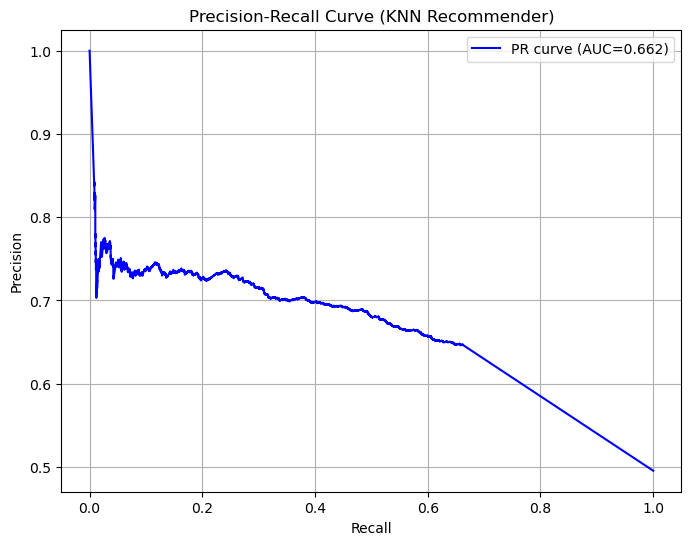

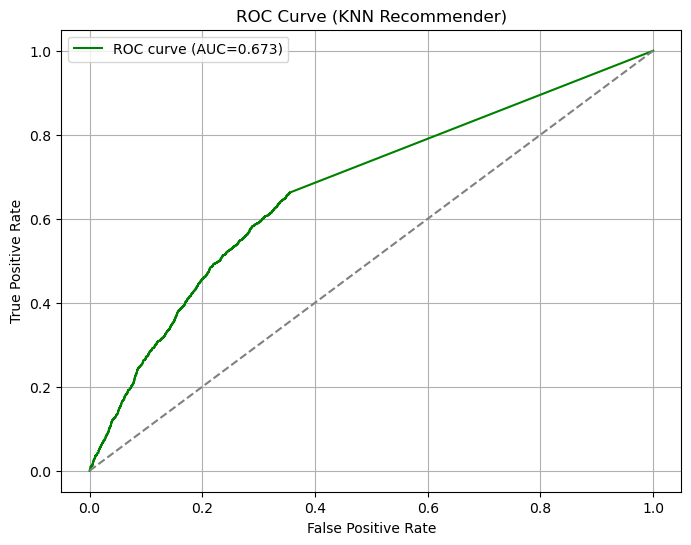

In [23]:
precision, recall, pr_thresholds = precision_recall_curve(y_true, y_scores)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f'PR curve (AUC={pr_auc:.3f})', color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (KNN Recommender)')
plt.legend()
plt.grid(True)
plt.show()

fpr, tpr, roc_thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC={roc_auc:.3f})', color='green')
plt.plot([0,1], [0,1], '--', color='gray')  # random baseline
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (KNN Recommender)')
plt.legend()
plt.grid(True)
plt.show()

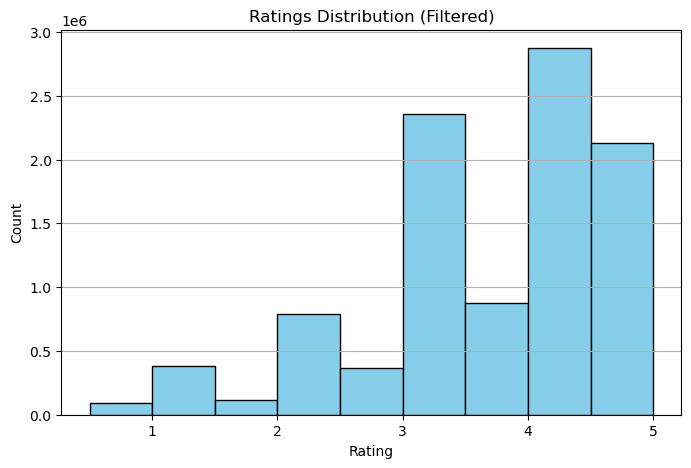

In [24]:
plt.figure(figsize=(8,5))
plt.hist(ratings_filtered['rating'], bins=np.arange(0.5, 5.5, 0.5), color='skyblue', edgecolor='black')
plt.title("Ratings Distribution (Filtered)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.grid(axis='y')
plt.show()

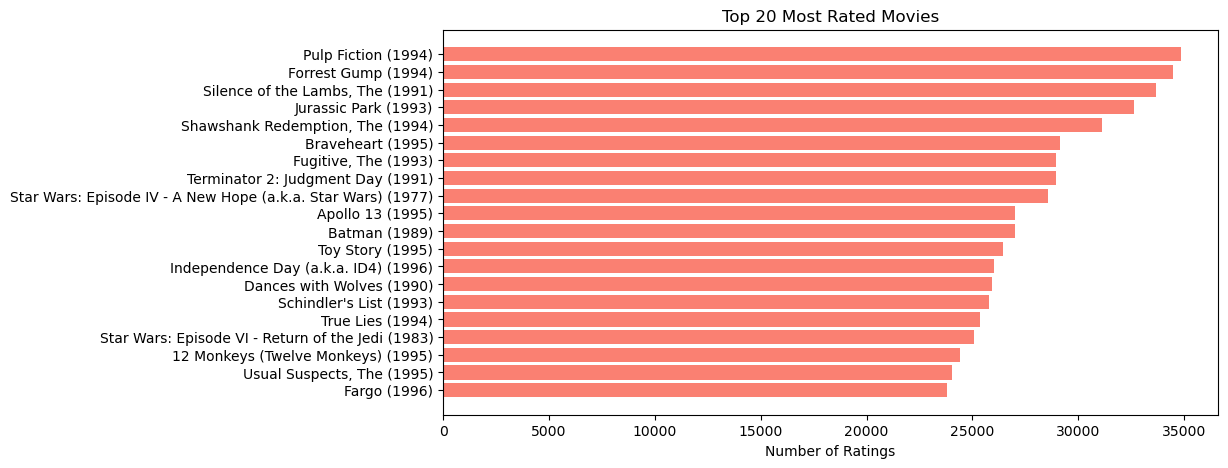

In [25]:
top_movie_counts = ratings_filtered['movieId'].value_counts().head(20)
top_movie_titles = [movieid_to_title[mid] for mid in top_movie_counts.index]

plt.figure(figsize=(10,5))
plt.barh(top_movie_titles[::-1], top_movie_counts.values[::-1], color='salmon')
plt.title("Top 20 Most Rated Movies")
plt.xlabel("Number of Ratings")
plt.show()